In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ys19-2023-assignment-4a/sample_submission.csv
/kaggle/input/ys19-2023-assignment-4a/test_set.csv
/kaggle/input/ys19-2023-assignment-4a/valid_set.csv
/kaggle/input/ys19-2023-assignment-4a/train_set.csv


## Downloads

In [2]:
# spaCy for Greek language handling
!python -m spacy download el_core_news_md
# pandarallel for faster applying of functions to dataframes. Need for tokens, lemmas etc.
!pip install unidecode
!pip install pandarallel
!pip install torch
!pip install unicodedata
!pip install transfomers

print("\n")
print("INSTALLATIONS COMPLETE.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 MB 33.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_md')
  Preparing metadata (setup.py) ... - done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=dbc20c92db4ee11b4c065bc7871ffa566fe77a234960d145ee91addd17dcb5d9
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
ERROR: Could not find a version that satisfies the requirement unicodedata (from versions: none)
ERROR: No matching distribution found for unicodedata
ERROR: Could not find a version that satisfies the requirement transfomers (from versions: none)
ERROR: No matching distribution found for transfomers


INSTALLATIONS COMPLETE.


## Imports

In [3]:
import spacy
from pandarallel import pandarallel
from sklearn.linear_model import LogisticRegression
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve,f1_score
from matplotlib import pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata as ud
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV
import optuna
from scipy.sparse import hstack
import nltk
import random
from torch.nn.utils import clip_grad_norm_
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import time

# HW2 new imports
import torch
import torch.nn as nn
import torch.nn.functional as F

print('Imports done.')

Imports done.


## Data preprocessing

In [4]:
nlp = spacy.load('el_core_news_md')
df = pd.read_csv('/kaggle/input/ys19-2023-assignment-4a/train_set.csv')
valid_df = pd.read_csv('/kaggle/input/ys19-2023-assignment-4a/valid_set.csv')
test_df = pd.read_csv('/kaggle/input/ys19-2023-assignment-4a/test_set.csv')

df.head()

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


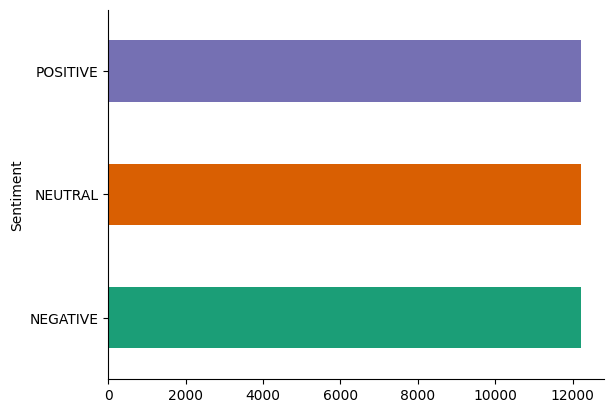

In [5]:
# Visualize our data (specifically the Sentiment column)
# Data Distribution

df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Sentiment', ylabel='count'>

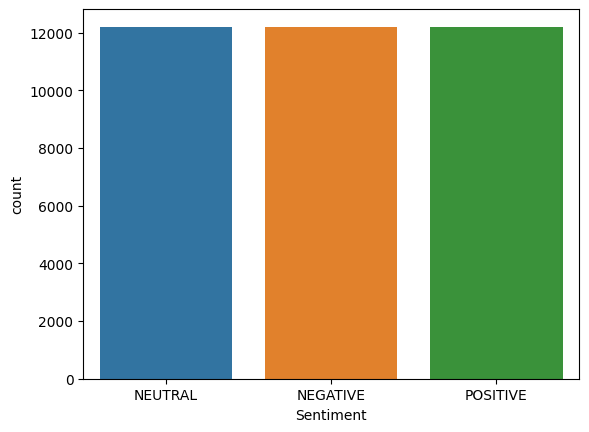

In [6]:
# Countplot for column Sentiment, Sentiment values are of the same number for each sentiment
sns.countplot(x='Sentiment',data=df)

<Axes: xlabel='Party', ylabel='count'>

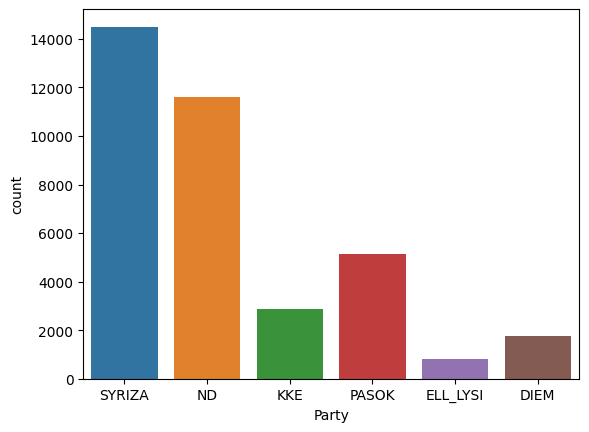

In [7]:
# Countplot for Parties , We can see that SYRIZA is the most prevalent party in the tweets dataset
sns.countplot(x='Party',data=df)

In [8]:
# Check for null values
df.isnull().sum()

# Create stop word list for word cloud and word frequency
stop_words = 'amp,αδιακοπα, αι, ακομα, ακομη, ακριβως, αληθεια, αληθινα, αλλα, αλλαχου, αλλες, αλλη, αλλην, αλλης, αλλιως, αλλιωτικα, αλλο, αλλοι, αλλοιως, αλλοιωτικα, αλλον, αλλος, αλλοτε, αλλου, αλλους, αλλων, αμα, αμεσα, αμεσως, αν, ανα, αναμεσα, αναμεταξυ, ανευ, αντι, αντιπερα, αντις, ανω, ανωτερω, αξαφνα, απ, απεναντι, απο, αποψε, αρα, αραγε, αργα, αργοτερο, αριστερα, αρκετα, αρχικα, ας, αυριο, αυτα, αυτες, αυτη, αυτην, αυτης, αυτο, αυτοι, αυτον, αυτος, αυτου, αυτους, αυτων, αφοτου, αφου, βεβαια, βεβαιοτατα, γι, για, γρηγορα, γυρω, δα, δε, δεινα, δεν, δεξια, δηθεν, δηλαδη, δι, δια, διαρκως, δικα, δικο, δικοι, δικος, δικου, δικους, διολου, διπλα, διχως, εαν, εαυτο, εαυτον, εαυτου, εαυτους, εαυτων, εγκαιρα, εγκαιρως, εγω, εδω, ειδεμη, ειθε, ειμαι, ειμαστε, ειναι, εις, εισαι, εισαστε, ειστε, ειτε, ειχα, ειχαμε, ειχαν, ειχατε, ειχε, ειχες, εκαστα, εκαστες, εκαστη, εκαστην, εκαστης, εκαστο, εκαστοι, εκαστον, εκαστος, εκαστου, εκαστους, εκαστων, εκει, εκεινα, εκεινες, εκεινη, εκεινην, εκεινης, εκεινο, εκεινοι, εκεινον, εκεινος, εκεινου, εκεινους, εκεινων, εκτος, εμας, εμεις, εμενα, εμπρος, εν, ενα, εναν, ενας, ενος, εντελως, εντος, εντωμεταξυ, ενω, εξ, εξαφνα, εξης, εξισου, εξω, επανω, επειδη, επειτα, επι, επισης, επομενως, εσας, εσεις, εσενα, εστω, εσυ, ετερα, ετεραι, ετερας, ετερες, ετερη, ετερης, ετερο, ετεροι, ετερον, ετερος, ετερου, ετερους, ετερων, ετουτα, ετουτες, ετουτη, ετουτην, ετουτης, ετουτο, ετουτοι, ετουτον, ετουτος, ετουτου, ετουτους, ετουτων, ετσι, ευγε, ευθυς, ευτυχως, εφεξης, εχει, εχεις, εχετε, εχθες, εχομε, εχουμε, εχουν, εχτες, εχω, εως, η, ηδη, ημασταν, ημαστε, ημουν, ησασταν, ησαστε, ησουν, ηταν, ητανε, ητοι, ηττον, θα, ι, ιδια, ιδιαν, ιδιας, ιδιες, ιδιο, ιδιοι, ιδιον, ιδιος, ιδιου, ιδιους, ιδιων, ιδιως, ιι, ιιι, ισαμε, ισια, ισως,κ,καθε, καθεμια, καθεμιας, καθενα, καθενας, καθενος, καθετι, καθολου, καθως, και, κακα, κακως, καλα, καλως, καμια, καμιαν, καμιας, καμποσα, καμποσες, καμποση, καμποσην, καμποσης, καμποσο, καμποσοι, καμποσον, καμποσος, καμποσου, καμποσους, καμποσων, κανεις, κανεν, κανενα, κανεναν, κανενας, κανενος, καποια, καποιαν, καποιας, καποιες, καποιο, καποιοι, καποιον, καποιος, καποιου, καποιους, καποιων, καποτε, καπου, καπως, κατ ,κατα, κατι, κατιτι, κατοπιν, κατω, κιολας,κι, κλπ, κοντα, κτλ, κυριως, λιγακι, λιγο, λιγωτερο, λογω, λοιπα, λοιπον, μα, μαζι, μακαρι, μακρυα, μαλιστα, μαλλον, μας, με, μεθαυριο, μειον, μελει, μελλεται, μεμιας, μεν, μερικα, μερικες, μερικοι, μερικους, μερικων, μεσα, μετ, μετα, μεταξυ, μεχρι, μη, μηδε, μην, μηπως, μητε, μια, μιαν, μιας, μολις, μολονοτι, μοναχα, μονες, μονη, μονην, μονης, μονο, μονοι, μονομιας, μονος, μονου, μονους, μονων, μου, μπορει, μπορουν, μπραβο, μπρος, να, ναι, νωρις, ξανα, ξαφνικα, ο, οι, ολα, ολες, ολη, ολην, ολης, ολο, ολογυρα, ολοι, ολον, ολονεν, ολος, ολοτελα, ολου, ολους, ολων, ολως, ολωσδιολου, ομως, οποια, οποιαδηποτε, οποιαν, οποιανδηποτε, οποιας, οποιασδηποτε, οποιδηποτε, οποιες, οποιεσδηποτε, οποιο, οποιοδηποτε, οποιοι, οποιον, οποιονδηποτε, οποιος, οποιοσδηποτε, οποιου, οποιουδηποτε, οποιους, οποιουσδηποτε, οποιων, οποιωνδηποτε, οποτε, οποτεδηποτε, οπου, οπουδηποτε, οπως, ορισμενα, ορισμενες, ορισμενων, ορισμενως, οσα, οσαδηποτε, οσες, οσεσδηποτε, οση, οσηδηποτε, οσην, οσηνδηποτε, οσης, οσησδηποτε, οσο, οσοδηποτε, οσοι, οσοιδηποτε, οσον, οσονδηποτε, οσος, οσοσδηποτε, οσου, οσουδηποτε, οσους, οσουσδηποτε, οσων, οσωνδηποτε, οταν, οτι, οτιδηποτε, οτου, ου, ουδε, ουτε, οχι, παλι, παντοτε, παντου, παντως, παρα, περα, περι, περιπου, περισσοτερο, περσι, περυσι, πια, πιθανον, πιο, πισω, πλαι, πλεον, πλην, ποια, ποιαν, ποιας, ποιες, ποιο, ποιοι, ποιον, ποιος, ποιου, ποιους, ποιων, πολυ, ποσες, ποση, ποσην, ποσης, ποσοι, ποσος, ποσους, ποτε, που, πουθε, πουθενα, πρεπει, πριν, προ, προκειμενου, προκειται, προπερσι, προς, προτου, προχθες, προχτες, πρωτυτερα, πως, σαν, σας, σε, σεις, σημερα, σιγα, σου, στα, στη, στην, στης, στις, στο, στον, στου, στους, στων, συγχρονως, συν, συναμα, συνεπως, συνηθως, συχνα, συχνας, συχνες, συχνη, συχνην, συχνης, συχνο, συχνοι, συχνον, συχνος, συχνου, συχνου, συχνους, συχνων, συχνως, σχεδον, σωστα, τα, ταδε, ταυτα, ταυτες, ταυτη, ταυτην, ταυτης, ταυτο,ταυτον, ταυτος, ταυτου, ταυτων, ταχα, ταχατε, τελικα, τελικως, τες, τετοια, τετοιαν, τετοιας, τετοιες, τετοιο, τετοιοι, τετοιον, τετοιος, τετοιου, τετοιους, τετοιων, τη, την, της, τι, τιποτα, τιποτε, τις, το, τοι, τον, τος, τοσα, τοσες, τοση, τοσην, τοσης, τοσο, τοσοι, τοσον, τοσος, τοσου, τοσους, τοσων, τοτε, του, τουλαχιστο, τουλαχιστον, τους, τουτα, τουτες, τουτη, τουτην, τουτης, τουτο, τουτοι, τουτοις, τουτον, τουτος, τουτου, τουτους, τουτων, τυχον, των, τωρα, υπ, υπερ, υπο, υποψη, υποψιν, υστερα, φετος, χαμηλα, χθες, χτες, χωρις, χωριστα, ψηλα, ω, ωραια, ως, ωσαν, ωσοτου, ωσπου, ωστε, ωστοσο, ωχ'


stop_words_separated = stop_words.split(",")
stop_words_separated = [w.strip() for w in stop_words_separated] # remove whitespaces

# remove diacritics
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

for word in stop_words_separated:
    word = ud.normalize('NFD',word).translate(d)

print('Stop words created.')

Stop words created.


In [9]:
# Data cleanup
# Remove all useless characters from tweets (URLs, Hashtags, mentions (at signs), punctuations)
# also removes mentioned accounts after hashtags and @ signs and special symbols.
def clean_tweet(tweet):
    '''
    Function to clean a tweet text by removing the links, punctuations, hashtags, mentions symbols and every text after mentions and hashtags
    using regex expressions. Also removes special symbols.
    Parameters:
       tweet (string): Tweet text to transform.
    Returns:
       tweet_cleaned (string): Tweet without links, punctuations, hashtags, ,mentions symbols and every text after mentions and hashtags. Also removes special symbols.
    """
    '''
    # convert the tweet text to lowercase letters
    tweet_lower = tweet.lower()
    # remove links, punctuations, hashtags, ,mentions and other symbols
    tweet_cleaned = re.sub(u"(http\S+)|([“”!?.»«,:;()\"'%&-_|–€$΄#])|([#@]\S+)", "", tweet_lower)
    
    return tweet_cleaned

# Apply function to all tweets (text column)
df['Text'] = [clean_tweet(tweet) for tweet in df['Text']]
test_df['Text'] = [clean_tweet(tweet) for tweet in test_df['Text']]
valid_df['Text'] = [clean_tweet(tweet) for tweet in valid_df['Text']]

def find_english_words(text):
    return re.findall(r'\b[a-zA-Z]+\b', text)

english_words = [find_english_words(text) for text in df['Text']]
test_english_words = [find_english_words(text) for text in test_df['Text']]
valid_english_words = [find_english_words(text) for text in valid_df['Text']]

def lists_to_list_skip_empty(list_of_lists):
    # Flatten the list of lists, skipping empty lists
    flat_list = [item for sublist in list_of_lists if sublist for item in sublist]
    return flat_list

final_list = lists_to_list_skip_empty(english_words)
final_list_no_dupes = list(set(final_list))

test_final_list = lists_to_list_skip_empty(test_english_words)
test_final_list_no_dupes = list(set(test_final_list))

valid_final_list = lists_to_list_skip_empty(valid_english_words)
valid_final_list_no_dupes = list(set(valid_final_list))

stop_words_separated.extend(final_list_no_dupes) # add English words to stop words so they can be removed.
stop_words_separated.extend(test_final_list_no_dupes)
stop_words_separated.extend(valid_final_list_no_dupes)

# remove diacritics from Text column
text_no_diacritics = []
test_no_diacritics = []
valid_no_diacritics = []

d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
for tweet in df['Text']:
    text1 = ud.normalize('NFD',tweet).translate(d)
    text_no_diacritics.append(text1)
    
for tweet in test_df['Text']:
    text2 = ud.normalize('NFD',tweet).translate(d)
    test_no_diacritics.append(text2)

for tweet in valid_df['Text']:
    text3 = ud.normalize('NFD',tweet).translate(d)
    valid_no_diacritics.append(text3)
    
df['Text'] = text_no_diacritics
test_df['Text'] = test_no_diacritics
valid_df['Text'] = valid_no_diacritics

# Remove stop_words from text column
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))
valid_df['Text'] = valid_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))

print(df['Text']) # making sure the cleanup works.
print('\n')
print('TEST SET BELOW')
print(test_df['Text'])
print('\n')
print('VALID SET BELOW')
print(valid_df['Text'])

# Using pandarallel for faster tokenization and lemmatization.
# pandarallel.initialize(progress_bar=True)

# I added comments to these columns as they took a considerable amount of time to be finished , and they're not usable
# since they produce worse results.
# df['Docs'] = df['Text'].parallel_apply(lambda x: nlp(x)) # add docs to dataframe in order to get tokens
# df['Lemmas'] = df['Text'].parallel_apply(lambda row: " ".join([w.lemma_ for w in nlp(row)])) # add lemmas to dataframe
print("Text cleanup complete.")

0        απολυμανσηκοριοι απεντομωσηκοριος απολυμανσεις...
1        εξι νεες επιστολες μακεδονια καινε νδ μητσοτακ...
2         ισχυρο κκε δυναμη λαου βουλη καθημερινους αγωνες
3                      μνημονιακοτατο μερα εκλογες τωρακκε
4                         συγκλονιστικο ψυχασθενεια τσιπρα
                               ...                        
36625    κουλης μητσοτακης λεει ψεματαδεν αδειασε μπαμπ...
36626    προσεξε σκισει καλσον χαλια νεα φωτογραφια ομο...
36627    θεση κκε ασφαλεια πολιτων διαφορους ρουβικωνες...
36628    μαρη κακομοιρα θυγατερα ναζιστη αντισημιτη ξεφ...
36629                              ενταξει επεισες κκε 🤘❤️
Name: Text, Length: 36630, dtype: object


TEST SET BELOW
0        κυριακος μητσοτακης ξερει μουσειο βεργινας μεσ...
1        συνεντευξη υποψηφιας βουλευτη νεα δημοκρατια β...
2        εκλογες μαθητες φοιτητες ψηφιζουμε τροπο αγωνι...
3        γεννηματα κιναλ γινει δεκανικι ενδιαφερουν υπο...
4        κυριακη εκλογων οκτωβρης ξημερωματα δευτερας ξ..

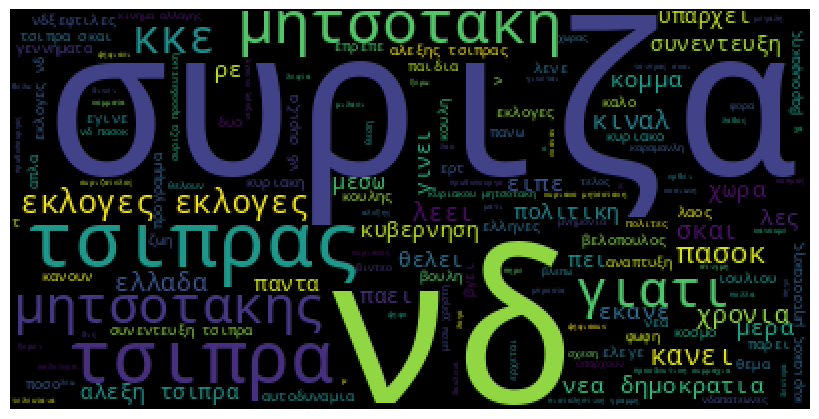

In [10]:
# Creating some visualizations with tokens
# Word cloud
tweets = []
for tweet in df['Text']:
    #tokens.append(doc.text)
    tweets.append(tweet)
    


# stop_words = stopwords.words('greek')
for i in range(len(tweets)):
        tweets[i] = tweets[i].lower()


# remove Diacritics in Greek (tonous)
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
tweets_string = "".join(tweets)
tweets_without_accent = ud.normalize('NFD',tweets_string).translate(d)


wordcloud = WordCloud(stopwords=stop_words_separated).generate(str(tweets_without_accent))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

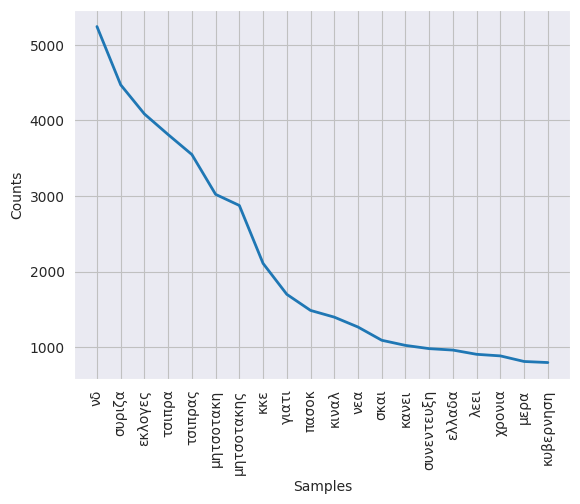

In [11]:
# Tokens frequency diagram
tokens = nltk.word_tokenize(tweets_without_accent)
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

In [12]:
# # Convert labels to one-hot encoded tensors
# label_embeddings_train = pd.get_dummies(df['Sentiment']).values
# label_embeddings_valid = pd.get_dummies(valid_df['Sentiment']).values

# # Below part is used to correlate the numbers 0,1,2 to their respective labels (POSITIVE,NEUTRAL,NEGATIVE) for predictions
# label_encoded_train = pd.get_dummies(df['Sentiment'])
# label_encoded_valid = pd.get_dummies(valid_df['Sentiment'])

# label_mapping_train = {i: label for i, label in enumerate(label_encoded_train.columns)}
# label_mapping_valid = {i: label for i, label in enumerate(label_encoded_valid.columns)}
# print(label_embeddings_train)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Create numerical labels for BERT model
train_numerical_labels = label_encoder.fit_transform(df['Sentiment'])
valid_numerical_labels = label_encoder.fit_transform(valid_df['Sentiment'])
print(valid_numerical_labels)

[2 0 0 ... 0 2 1]


## BERT model creation (GreekBERT)

In [13]:
tokenizer = BertTokenizer.from_pretrained('nlpaueb/bert-base-greek-uncased-v1')
model = BertForSequenceClassification.from_pretrained('nlpaueb/bert-base-greek-uncased-v1', num_labels=3, output_attentions = False, output_hidden_states = False)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Find max lengths of train,test, valid datasets in order to use it later for BERT
max_len = 0

# Train dataset
for tweet in df['Text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max tweet length (train): ', max_len)

max_len = 0

for tweet in test_df['Text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max tweet length (test): ', max_len)

max_len = 0

for tweet in valid_df['Text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    
print('Max tweet length (valid): ', max_len)

Max tweet length (train):  88
Max tweet length (test):  78
Max tweet length (valid):  59


In [15]:
train_input_ids = []
train_attention_masks = []


# Set the seed value to 42 in order to make experiment reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Side note: I've added max length to 128 here in order to make sure that there are no outlier tweets with more than 88 words.
# Train dataset encoding
for tweet in df['Text']:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Tweet to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all tweets.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True # truncate tweets to max length
                   )
    
    # Add the encoded tweet to the list.    
    train_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

# Move all tensors and model to GPU.
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:1")

# Make lists into tensors
train_input_ids = torch.cat(train_input_ids, dim=0).to(device)
train_attention_masks = torch.cat(train_attention_masks, dim=0).to(device)
train_labels = torch.tensor(train_numerical_labels).to(device)



train_input_ids = train_input_ids.to(device)
train_attention_masks = train_attention_masks.to(device)
train_labels = train_labels.to(device)
    
valid_input_ids = []
valid_attention_masks = []

# Valid dataset encoding
for tweet in valid_df['Text']:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Tweet to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all tweets.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True # truncate tweets to max length
                   )
    
    # Add the encoded tweet to the list.    
    valid_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    valid_attention_masks.append(encoded_dict['attention_mask'])


# Make lists into tensors and move them to GPU
valid_input_ids = torch.cat(valid_input_ids, dim=0).to(device)
valid_attention_masks = torch.cat(valid_attention_masks, dim=0).to(device)
valid_labels = torch.tensor(valid_numerical_labels).to(device)


# Create datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, train_labels)
valid_dataset = torch.utils.data.TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)


# Tokenize test data
test_input_ids = []
test_attention_masks = []

# Valid dataset encoding
for tweet in test_df['Text']:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Tweet to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all tweets.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True # truncate tweets to max length
                   )
    
    # Add the encoded tweet to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])


# Make lists into tensors and move them to GPU
test_input_ids = torch.cat(test_input_ids, dim=0).to(device)
test_attention_masks = torch.cat(test_attention_masks, dim=0).to(device)

# Create DataLoader for test data
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

print("Data loading complete.")

Data loading complete.


## Model training and evaluation (GreekBERT)

In [16]:
learning_rate = 2e-5
num_epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model.to(device)
training_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_predictions = []
    train_true_labels = []
    start_time = time.time()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        train_predictions.extend(predicted_labels.tolist())
        train_true_labels.extend(labels.tolist())
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Added gradient clipping as well
        optimizer.step()
    
    train_f1 = f1_score(train_true_labels, train_predictions, average='macro')
    training_f1_scores.append(train_f1)
    
    # Validation loop for f1-score to create Learning curve
    model.eval()
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            val_predictions.extend(predicted_labels.tolist())
            val_true_labels.extend(labels.tolist())
    
    
    # Calculate F1-score for validation set
    val_f1 = f1_score(val_true_labels, val_predictions, average='macro')
    val_f1_scores.append(val_f1)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_dataloader)}")
    print("Elapsed time:", elapsed_time, "seconds")
    print("\n")

# Validation loop for classification report
model.eval()
val_predictions = []
val_true_labels = []

with torch.no_grad():
    for batch in valid_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        val_predictions.extend(predicted_labels.tolist())
        val_true_labels.extend(labels.tolist())

# Calculate accuracy on validation set
accuracy = accuracy_score(val_true_labels, val_predictions)
print("Validation Accuracy:", accuracy)

Epoch 1, Average Loss: 1.09804923862349
Elapsed time: 744.48814702034 seconds


Epoch 2, Average Loss: 1.0682975061075135
Elapsed time: 749.0222232341766 seconds


Epoch 3, Average Loss: 1.035527489851656
Elapsed time: 749.1756024360657 seconds


Validation Accuracy: 0.4235474006116208


In [17]:
string_val_preds = label_encoder.inverse_transform(val_predictions)
string_val_true_labels = label_encoder.inverse_transform(val_true_labels)

print(classification_report(string_val_true_labels,string_val_preds))

print("accuracy: ",accuracy_score(string_val_true_labels,string_val_preds))
print("f1: ",f1_score(string_val_true_labels,string_val_preds,average='micro'))
print("total f1: ",f1_score(string_val_true_labels,string_val_preds,average=None))

              precision    recall  f1-score   support

    NEGATIVE       0.40      0.56      0.47      1744
     NEUTRAL       0.48      0.23      0.31      1744
    POSITIVE       0.43      0.49      0.45      1744

    accuracy                           0.42      5232
   macro avg       0.44      0.42      0.41      5232
weighted avg       0.44      0.42      0.41      5232

accuracy:  0.4235474006116208
f1:  0.4235474006116208
total f1:  [0.466795   0.31019775 0.45374095]


## Obtain predictions

In [18]:
# Test predictions
test_predictions = []

# Iterate over test set batches
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask = batch
    
    # Disable gradient calculation
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    
    # Convert predictions to CPU and append to test_predictions list
    test_predictions.extend(predictions.cpu().numpy())

# print("Test set predictions:", test_predictions)
print("Test prediction done.")

Test prediction done.


In [19]:
string_test_preds = label_encoder.inverse_transform(test_predictions)
print(string_test_preds[0])

POSITIVE


## BERT model creation (DistilGREEK-BERT)

In [20]:
distil_tokenizer = AutoTokenizer.from_pretrained('EftychiaKarav/DistilGREEK-BERT')
distil_model = AutoModelForSequenceClassification.from_pretrained('EftychiaKarav/DistilGREEK-BERT', num_labels=3, output_attentions = False, output_hidden_states = False)

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at EftychiaKarav/DistilGREEK-BERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Find max lengths of train,test, valid datasets in order to use it later for BERT
max_len = 0

# Train dataset
for tweet in df['Text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = distil_tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max tweet length (train): ', max_len)

max_len = 0

for tweet in test_df['Text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = distil_tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max tweet length (test): ', max_len)

max_len = 0

for tweet in valid_df['Text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = distil_tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    
print('Max tweet length (valid): ', max_len)

Max tweet length (train):  88
Max tweet length (test):  78
Max tweet length (valid):  59


In [22]:
train_input_ids = []
train_attention_masks = []


# Set the seed value to 42 in order to make experiment reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Side note: I've added max length to 128 here in order to make sure that there are no outlier tweets with more than 88 words.
# Train dataset encoding
for tweet in df['Text']:
    encoded_dict = distil_tokenizer.encode_plus(
                        tweet,                      # Tweet to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all tweets.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True # truncate tweets to max length
                   )
    
    # Add the encoded tweet to the list.    
    train_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

# Move all tensors and model to GPU.
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:1")

# Make lists into tensors
train_input_ids = torch.cat(train_input_ids, dim=0).to(device)
train_attention_masks = torch.cat(train_attention_masks, dim=0).to(device)
train_labels = torch.tensor(train_numerical_labels).to(device)



train_input_ids = train_input_ids.to(device)
train_attention_masks = train_attention_masks.to(device)
train_labels = train_labels.to(device)
    
valid_input_ids = []
valid_attention_masks = []

# Valid dataset encoding
for tweet in valid_df['Text']:
    encoded_dict = distil_tokenizer.encode_plus(
                        tweet,                      # Tweet to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all tweets.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True # truncate tweets to max length
                   )
    
    # Add the encoded tweet to the list.    
    valid_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    valid_attention_masks.append(encoded_dict['attention_mask'])


# Make lists into tensors and move them to GPU
valid_input_ids = torch.cat(valid_input_ids, dim=0).to(device)
valid_attention_masks = torch.cat(valid_attention_masks, dim=0).to(device)
valid_labels = torch.tensor(valid_numerical_labels).to(device)


# Create datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, train_labels)
valid_dataset = torch.utils.data.TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
print("Data loading complete.")

Data loading complete.


## Model training and evaluation (DistilGREEK-BERT)

In [23]:
# DistilGREEK-BERT experiment
learning_rate = 2e-5
num_epochs = 3
optimizer = torch.optim.AdamW(distil_model.parameters(), lr=learning_rate)

distil_model.to(device)

for epoch in range(num_epochs):
    distil_model.train()
    total_loss = 0
    start_time = time.time()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = distil_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(distil_model.parameters(), 1.0) # Added gradient clipping as well
        optimizer.step()
        
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_dataloader)}")
    print("Elapsed time:", elapsed_time, "seconds")
    print("\n")

# Validation loop
distil_model.eval()
val_predictions = []
val_true_labels = []
with torch.no_grad():
    for batch in valid_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = distil_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        val_predictions.extend(predicted_labels.tolist())
        val_true_labels.extend(labels.tolist())

# Calculate accuracy on validation set
accuracy = accuracy_score(val_true_labels, val_predictions)
print("Validation Accuracy:", accuracy)

Epoch 1, Average Loss: 1.1017932475394037
Elapsed time: 361.43935322761536 seconds


Epoch 2, Average Loss: 1.095171357346414
Elapsed time: 361.2671048641205 seconds


Epoch 3, Average Loss: 1.0892876822875577
Elapsed time: 361.1899003982544 seconds


Validation Accuracy: 0.4034785932721712


In [24]:
string_val_preds_distil = label_encoder.inverse_transform(val_predictions)
string_val_true_labels_distil = label_encoder.inverse_transform(val_true_labels)

print(classification_report(string_val_true_labels_distil,string_val_preds_distil))

print("accuracy: ",accuracy_score(string_val_true_labels_distil,string_val_preds_distil))
print("f1: ",f1_score(string_val_true_labels_distil,string_val_preds_distil,average='micro'))
print("total f1: ",f1_score(string_val_true_labels_distil,string_val_preds_distil,average=None))

              precision    recall  f1-score   support

    NEGATIVE       0.39      0.60      0.47      1744
     NEUTRAL       0.42      0.23      0.30      1744
    POSITIVE       0.42      0.38      0.40      1744

    accuracy                           0.40      5232
   macro avg       0.41      0.40      0.39      5232
weighted avg       0.41      0.40      0.39      5232

accuracy:  0.4034785932721712
f1:  0.4034785932721712
total f1:  [0.47111509 0.29596413 0.39915713]


## Confusion matrix , ROC and learning curves

In [25]:
conf_matrix = confusion_matrix(valid_df['Sentiment'],string_val_preds)
print(confusion_matrix(valid_df['Sentiment'],string_val_preds))

[[774 274 696]
 [824 266 654]
 [814 295 635]]


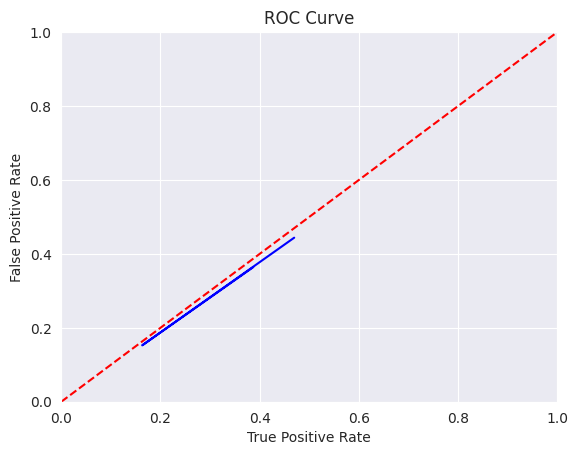

In [26]:
# ROC Curve
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix) #false positive
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix) # false negative
TP = np.diag(conf_matrix) # true positive
TN = conf_matrix.sum() - (FP + FN + TP) # True negative

TPR = TP/(TP+FN) # true positive rate
FPR = FP/(FP+TN) # false positive rate

plt.plot(FPR,TPR,'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

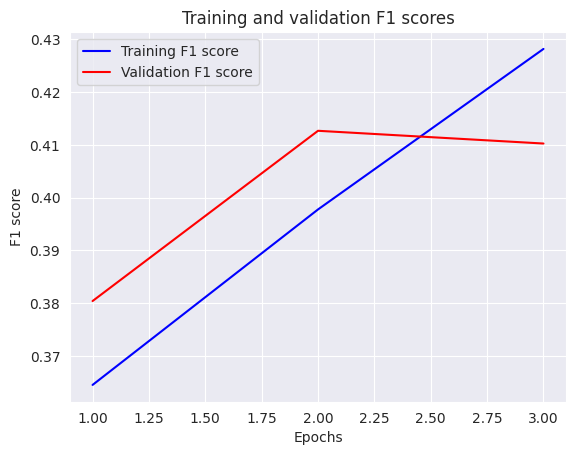

In [27]:
# Learning Curve
epochs = range(1, len(training_f1_scores) + 1)

# Plot learning curve
plt.plot(epochs, training_f1_scores, 'b', label='Training F1 score')
plt.plot(epochs, val_f1_scores, 'r', label='Validation F1 score')
plt.title('Training and validation F1 scores')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.show()

## Output file

In [28]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Id","Predicted"])
    for i in range(0,10470):
        writer.writerow([i+1,string_test_preds[i]])  
    
    
print("CSV file writing complete.")

CSV file writing complete.
